In [1]:
!pip install split-folders

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import kagglehub
import os
import random
import shutil
import pickle
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

In [3]:
#constraints
#classes
max_classes_num = 130

#images
img_size = (224,224)
batch_size = 32

#files settings paths, model/classes files
download_dir = kagglehub.dataset_download("thedevastator/anime-face-dataset-by-character-name")
input_dir = "/kaggle/modifiedInput/AnimeFaceRecognition"
output_dir = "/kaggle/output/AnimeFaceRecognition"
dataset_source_dir = os.path.join(download_dir, "dataset")

#variables
#classes
classes_num = 10

#model
epochs_num = 25

#files settings paths, model/classes files
model_name = "anime_face_recognition_model"
model_output_dir = "/kaggle/output/models"

100%|██████████| 57.9M/57.9M [00:00<00:00, 101MB/s]

Extracting files...


In [4]:
if os.path.exists(dataset_source_dir):
  print(f"Dataset downloaded successfully in {dataset_source_dir}")

  os.makedirs(input_dir, exist_ok=True)
  dataset_target_dir = os.path.join(input_dir, "dataset")
  os.makedirs(dataset_target_dir, exist_ok=True)
  os.makedirs(model_output_dir, exist_ok=True)

  all_classes = os.listdir(dataset_source_dir)
  selected_classes = random.sample(all_classes, classes_num % max_classes_num)
  selected_classes.sort()

  for class_name in selected_classes:
    class_source_dir = os.path.join(dataset_source_dir, class_name)
    class_target_dir = os.path.join(dataset_target_dir, class_name)

    shutil.copytree(class_source_dir, class_target_dir)
    print(f"Copied {class_name} class")

  with open(model_output_dir + "/" + model_name + ".pkl", "wb") as f:
    pickle.dump(selected_classes, f)
    print(f"Class names saved to: {model_output_dir}")

  print("Dataset copied successfully")

  split_ratio = (0.8, 0.1, 0.1)

  splitfolders.ratio(
      dataset_target_dir,
      output=output_dir,
      seed=500,
      ratio=split_ratio,
      group_prefix=None
  )
else:
  print("Dataset download failed.")

Dataset downloaded successfully in /root/.cache/kagglehub/datasets/thedevastator/anime-face-dataset-by-character-name/versions/1/dataset
Copied bremerton_(azur_lane) class
Copied chitanda_eru class
Copied kaname_madoka class
Copied kiryu_coco class
Copied kochou_shinobu class
Copied meltlilith class
Copied platelet_(hataraku_saibou) class
Copied ryougi_shiki class
Copied takao_(azur_lane) class
Copied toujou_nozomi class
Class names saved to: /kaggle/output/models
Dataset copied successfully


Copying files: 750 files [00:00, 1197.93 files/s]


In [5]:
train_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)

In [6]:
#Data augmentation for test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#Data augmentation form validation data
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
valid_dir = os.path.join(output_dir, "val")

train_data = train_datagen.flow_from_directory(
  train_dir,
  target_size=img_size,
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=True
)

test_data = test_datagen.flow_from_directory(
  test_dir,
  target_size=img_size,
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=False
)

valid_data = valid_datagen.flow_from_directory(
  valid_dir,
  target_size=img_size,
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=False
)

Found 600 images belonging to 10 classes.
Found 80 images belonging to 10 classes.
Found 70 images belonging to 10 classes.


Class indices mapping:
{'bremerton_(azur_lane)': 0, 'chitanda_eru': 1, 'kaname_madoka': 2, 'kiryu_coco': 3, 'kochou_shinobu': 4, 'meltlilith': 5, 'platelet_(hataraku_saibou)': 6, 'ryougi_shiki': 7, 'takao_(azur_lane)': 8, 'toujou_nozomi': 9}
Number of classes: 10
Selected classes: ['bremerton_(azur_lane)', 'chitanda_eru', 'kaname_madoka', 'kiryu_coco', 'kochou_shinobu', 'meltlilith', 'platelet_(hataraku_saibou)', 'ryougi_shiki', 'takao_(azur_lane)', 'toujou_nozomi']


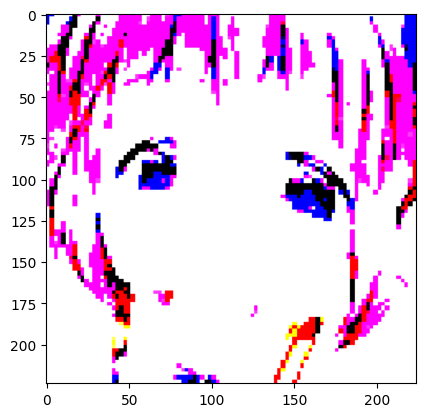

In [8]:
print("Class indices mapping:")
print(train_data.class_indices)
print(f"Number of classes: {train_data.num_classes}")
print(f"Selected classes: {selected_classes}")

#batch of images and labels
images, labels = next(valid_data)

#select a random image from the batch
idx = np.random.randint(0, images.shape[0] - 1)

plt.imshow(images[idx])
plt.show()

In [9]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

#freeze the convolutional base
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')
])

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_data, epochs=epochs_num, validation_data=valid_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.1882 - loss: 2.8323 - val_accuracy: 0.4857 - val_loss: 1.7626
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 129s 7s/step - accuracy: 0.3370 - loss: 1.8281 - val_accuracy: 0.5857 - val_loss: 1.3469
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.4700 - loss: 1.5122 - val_accuracy: 0.7000 - val_loss: 1.0835
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 127s 7s/step - accuracy: 0.6108 - loss: 1.1571 - val_accuracy: 0.6714 - val_loss: 1.0472
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.6340 - loss: 1.1495 - val_accuracy: 0.7714 - val_loss: 0.9022
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.6742 - loss: 0.9421 - val_accuracy: 0.7571 - val_loss: 0.8513
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 130s 7s/step - accuracy: 0.7020 - loss: 0.8474 - val_accuracy: 0.7571 - val_loss: 0.8100
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.7264 - loss: 0.8114 - val_accuracy: 0.7857 - v

In [13]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.9016 - loss: 0.3001
Test accuracy: 91.25%


In [14]:
def predict_img(image, model):
  test_img = cv2.imread(image)
  test_img = cv2.resize(test_img, img_size)
  test_img = test_img.astype(np.float32)
  test_img = preprocess_input(test_img)
  test_img = np.expand_dims(test_img, axis=0)
  result = model.predict(test_img)
  r = np.argmax(result)
  print(selected_classes[r])

In [15]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def generate_confusion_matrix_fixed(model, test_data, class_names):
    """
    POPRAWIONA wersja generowania confusion matrix
    """
    print("Generating predictions for confusion matrix...")

    # Reset generatora
    test_data.reset()

    # Zbierz wszystkie predykcje i prawdziwe etykiety
    all_predictions = []
    all_true_labels = []

    # Iteruj przez wszystkie batche
    for i in range(len(test_data)):
        batch_images, batch_labels = test_data[i]

        # Predykcje dla batcha
        batch_predictions = model.predict(batch_images, verbose=0)

        # Dodaj do listy
        all_predictions.extend(batch_predictions)
        all_true_labels.extend(batch_labels)

    # Konwertuj na numpy arrays
    all_predictions = np.array(all_predictions)
    all_true_labels = np.array(all_true_labels)

    # Konwertuj one-hot na indeksy klas
    predicted_classes = np.argmax(all_predictions, axis=1)
    true_classes = np.argmax(all_true_labels, axis=1)

    print(f"Total samples: {len(true_classes)}")
    print(f"Unique predicted classes: {np.unique(predicted_classes)}")
    print(f"Unique true classes: {np.unique(true_classes)}")

    # Generuj confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Sprawdź rozmiary
    print(f"Confusion matrix shape: {cm.shape}")
    print(f"Number of class names: {len(class_names)}")

    # Wykreśl confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm, predicted_classes, true_classes

def generate_classification_report(true_classes, predicted_classes, class_names):
    """
    Generuje raport klasyfikacji
    """
    report = classification_report(true_classes, predicted_classes,
                                 target_names=class_names, output_dict=True)

    # Convert to DataFrame for better visualization
    df_report = pd.DataFrame(report).transpose()

    print("Classification Report:")
    print("=" * 60)
    print(df_report.round(3))

    return df_report

def visualize_predictions_fixed(model, test_data, class_names, num_images=9):
    """
    POPRAWIONA wersja wizualizacji predykcji
    """
    # Reset generatora
    test_data.reset()

    # Pobierz batch obrazów
    test_images, test_labels = next(test_data)

    # Ogranicz liczbę obrazów
    num_images = min(num_images, len(test_images))

    # Predykcje dla całego batcha
    predictions = model.predict(test_images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)

    # Wykres
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)

        # Przygotuj obraz do wyświetlenia
        img = test_images[i].copy()

        # Cofnij preprocessing ResNet50 (przybliżenie)
        # ResNet50 preprocessing: (x / 255.0 - mean) / std
        # gdzie mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])

        # Cofnij normalizację
        img = img * std + mean
        img = np.clip(img, 0, 1)

        plt.imshow(img)

        # Kolor tytułu w zależności od poprawności predykcji
        color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
        confidence = predictions[i][predicted_classes[i]] * 100

        plt.title(f'True: {class_names[true_classes[i]]}\n'
                 f'Pred: {class_names[predicted_classes[i]]}\n'
                 f'Conf: {confidence:.1f}%', color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Starting complete evaluation...
=== COMPLETE MODEL EVALUATION ===

1. Generating training history plots...


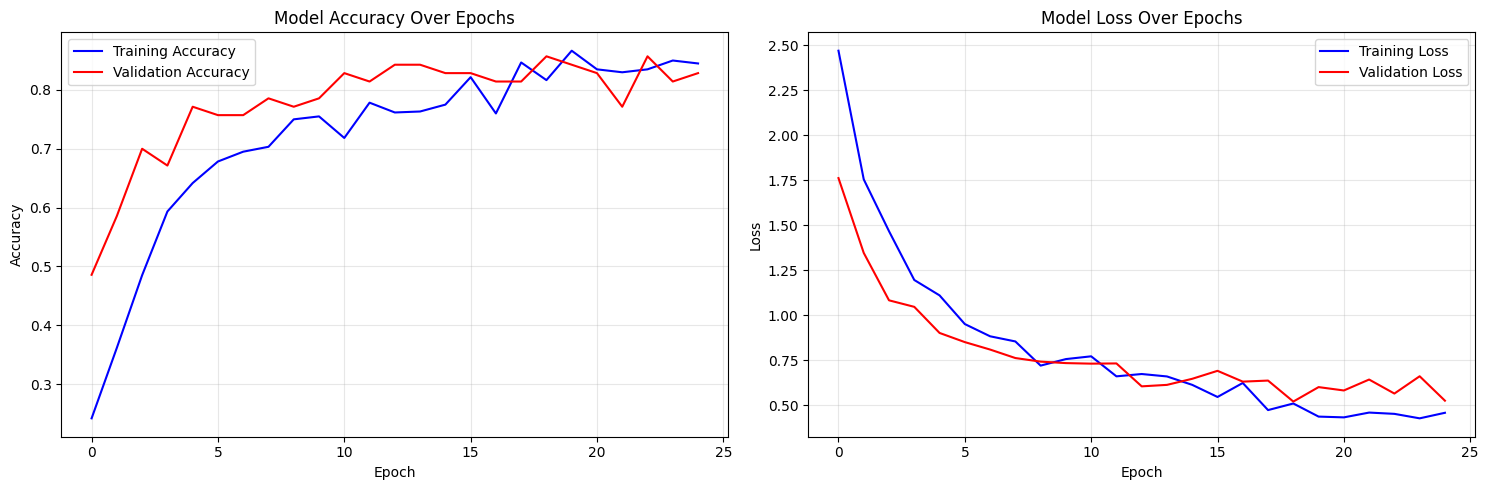


2. Generating confusion matrix...
Generating predictions for confusion matrix...
Total samples: 80
Unique predicted classes: [0 1 2 3 4 5 6 7 8 9]
Unique true classes: [0 1 2 3 4 5 6 7 8 9]
Confusion matrix shape: (10, 10)
Number of class names: 10


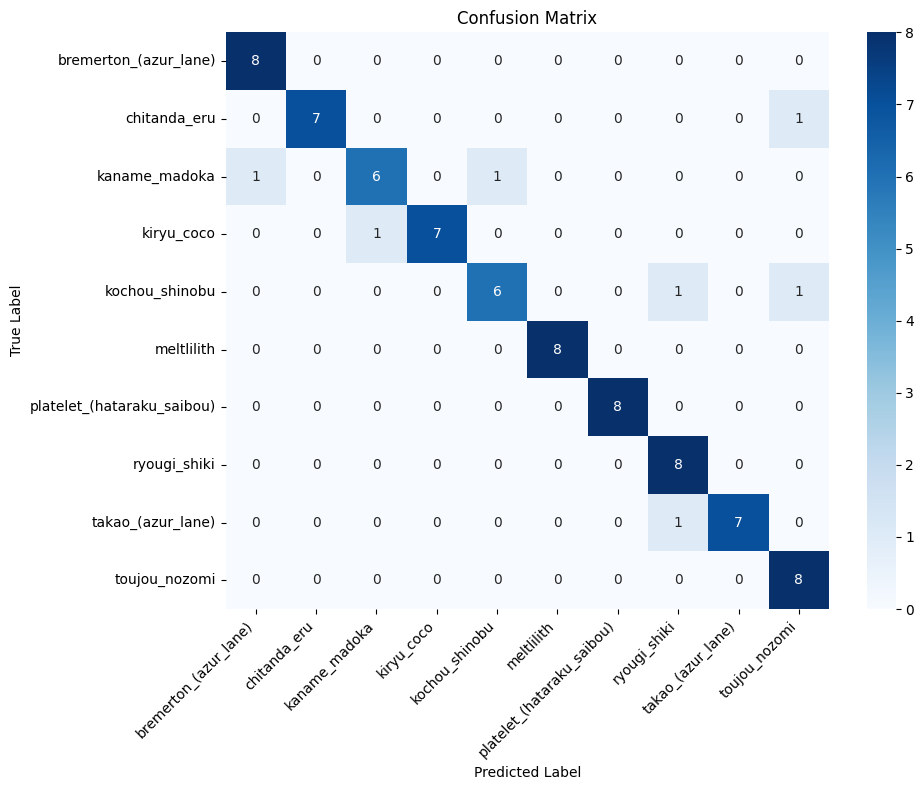


3. Generating classification report...
Classification Report:
                            precision  recall  f1-score  support
bremerton_(azur_lane)           0.889   1.000     0.941    8.000
chitanda_eru                    1.000   0.875     0.933    8.000
kaname_madoka                   0.857   0.750     0.800    8.000
kiryu_coco                      1.000   0.875     0.933    8.000
kochou_shinobu                  0.857   0.750     0.800    8.000
meltlilith                      1.000   1.000     1.000    8.000
platelet_(hataraku_saibou)      1.000   1.000     1.000    8.000
ryougi_shiki                    0.800   1.000     0.889    8.000
takao_(azur_lane)               1.000   0.875     0.933    8.000
toujou_nozomi                   0.800   1.000     0.889    8.000
accuracy                        0.912   0.912     0.912    0.912
macro avg                       0.920   0.912     0.912   80.000
weighted avg                    0.920   0.912     0.912   80.000

4. Visualizing sample pred

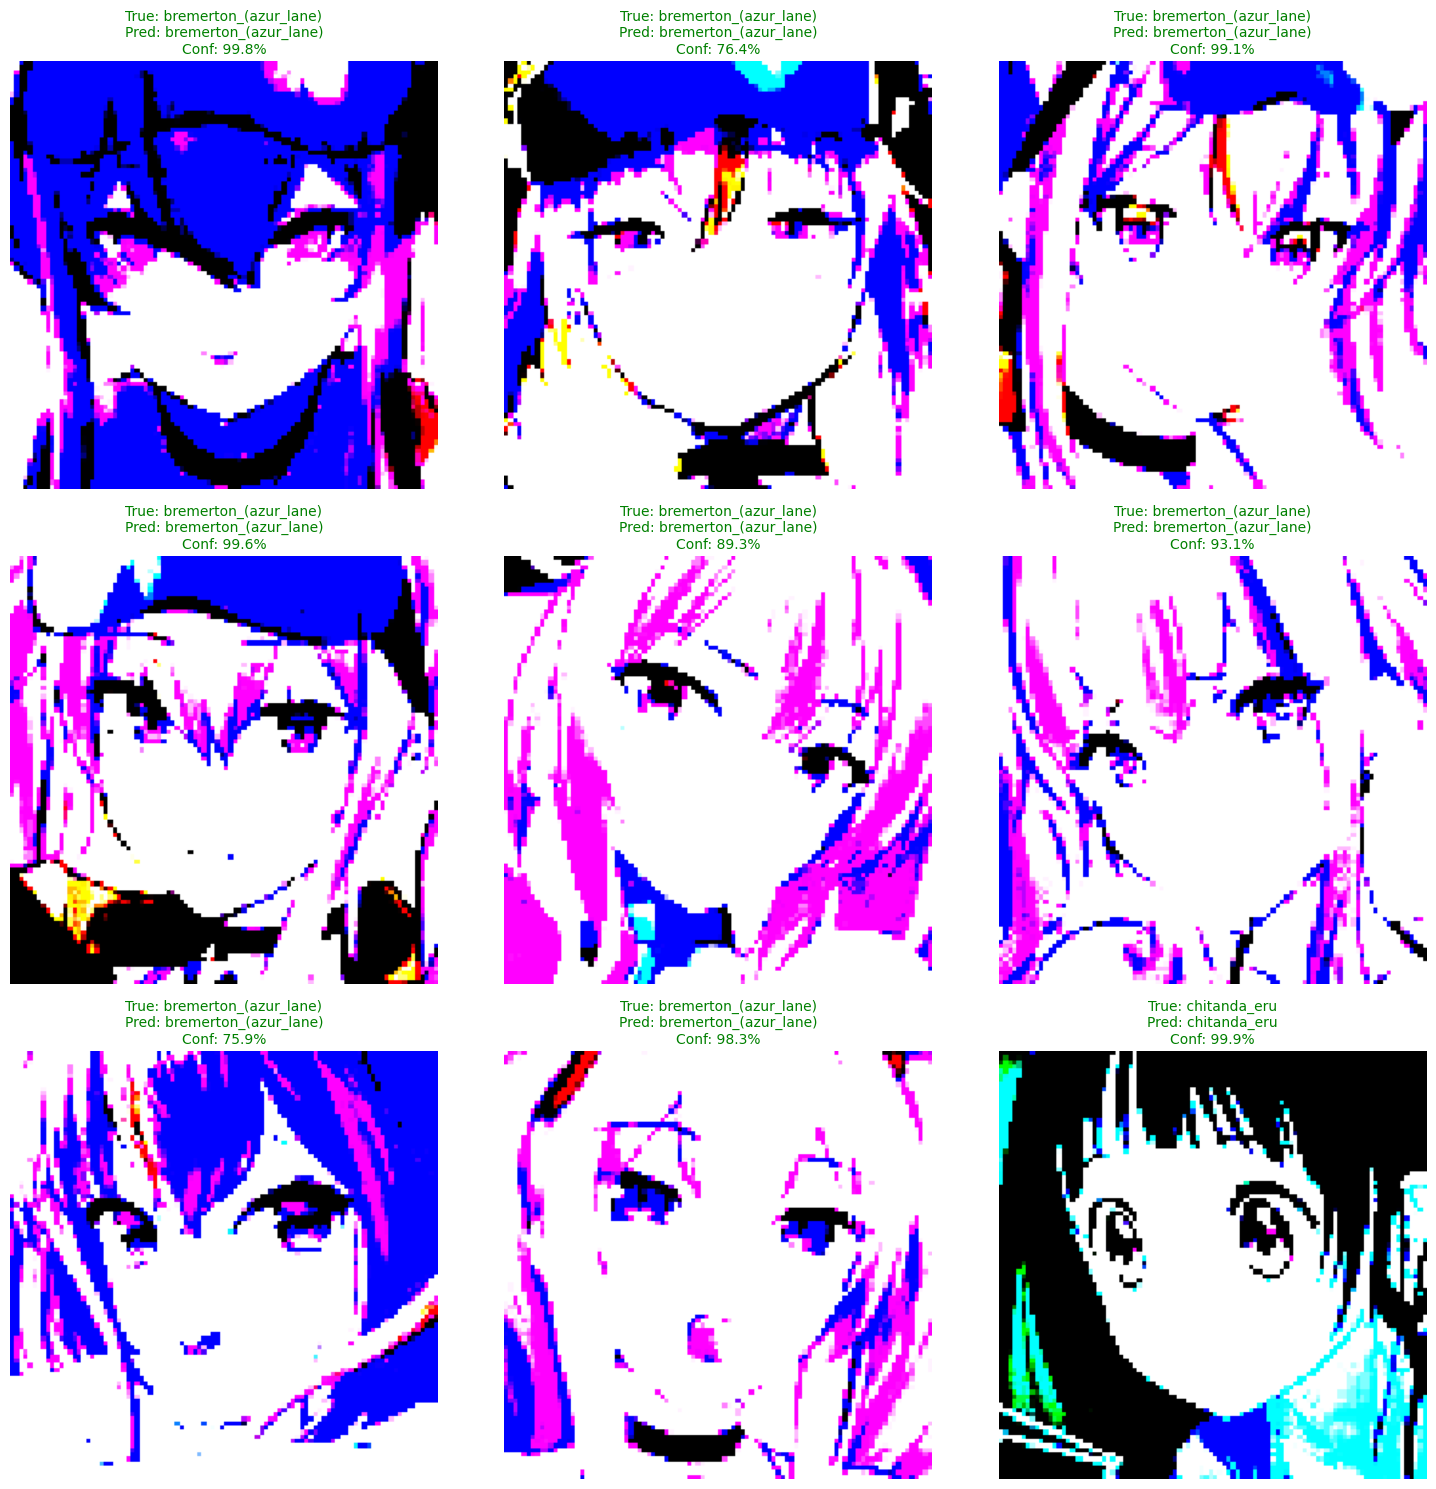


5. Summary statistics:
SUMMARY STATISTICS
Total test samples: 80
Number of classes: 10
Overall accuracy: 0.9125

Per-class accuracy:
  bremerton_(azur_lane): 1.0000 (8 samples)
  chitanda_eru: 0.8750 (8 samples)
  kaname_madoka: 0.7500 (8 samples)
  kiryu_coco: 0.8750 (8 samples)
  kochou_shinobu: 0.7500 (8 samples)
  meltlilith: 1.0000 (8 samples)
  platelet_(hataraku_saibou): 1.0000 (8 samples)
  ryougi_shiki: 1.0000 (8 samples)
  takao_(azur_lane): 0.8750 (8 samples)
  toujou_nozomi: 1.0000 (8 samples)


In [16]:
def run_complete_evaluation(model, test_data, class_names, history):
    """
    Uruchamia kompletną ewaluację z obsługą błędów
    """
    try:
        print("=== COMPLETE MODEL EVALUATION ===\n")

        print("1. Generating training history plots...")
        plot_training_history(history)

        print("\n2. Generating confusion matrix...")
        cm, predicted_classes, true_classes = generate_confusion_matrix_fixed(model, test_data, class_names)

        print("\n3. Generating classification report...")
        report_df = generate_classification_report(true_classes, predicted_classes, class_names)

        print("\n4. Visualizing sample predictions...")
        test_data.reset()
        visualize_predictions_fixed(model, test_data, class_names, num_images=9)

        print("\n5. Summary statistics:")
        print("=" * 60)
        print("SUMMARY STATISTICS")
        print("=" * 60)
        print(f"Total test samples: {len(true_classes)}")
        print(f"Number of classes: {len(class_names)}")
        print(f"Overall accuracy: {(predicted_classes == true_classes).mean():.4f}")

        print("\nPer-class accuracy:")
        for i, class_name in enumerate(class_names):
            class_mask = true_classes == i
            if class_mask.sum() > 0:
                class_accuracy = (predicted_classes[class_mask] == true_classes[class_mask]).mean()
                print(f"  {class_name}: {class_accuracy:.4f} ({class_mask.sum()} samples)")

        return cm, predicted_classes, true_classes, report_df

    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

print("Starting complete evaluation...")
cm, predicted_classes, true_classes, report_df = run_complete_evaluation(
    model, test_data, selected_classes, history
)

In [17]:
model.save(model_output_dir + "/" + model_name + ".h5")
model.save(model_output_dir + "/" + model_name + ".keras")

print(f"Model saved to {model_output_dir}")

Model saved to /kaggle/output/models


In [18]:
def predict_img_top3(image_path, model, class_names):
    """
    Predykcja z preprocessing + top 3 + pkl
    """
    try:
        test_img = cv2.imread(image_path)
        if test_img is None:
            print(f"Error: Could not load image {image_path}")
            return

        test_img = cv2.resize(test_img, img_size)
        test_img = test_img.astype(np.float32)
        test_img = preprocess_input(test_img)
        test_img = np.expand_dims(test_img, axis=0)

        result = model.predict(test_img, verbose=0)

        top_3_indices = np.argsort(result[0])[::-1][:3]

        print("TOP 3 PREDYKCJE:")
        for i, idx in enumerate(top_3_indices):
            confidence = result[0][idx] * 100
            print(f"{i+1}. {class_names[idx]}: {confidence:.2f}%")

    except Exception as e:
        print(f"Error in prediction: {e}")